In [1]:
"""
Work
請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果
"""


SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-1-3cb04d71f922>, line 3)

In [2]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
"""
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    ode Here
    建立你的神經網路
    
    return model

from keras.layers import BatchNormalization


建立神經網路，並加入 BN layer
"""
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [14]:
"""
import tensorflow as tf
import keras.backend as K

Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss

def combined_loss():
    Define the customized loss.

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]



import tensorflow as tf
import keras.backend as K


# 撰寫自定義的 loss function: focal loss (https://blog.csdn.net/u014380165/article/details/77019084)

import tensorflow as tf
import keras.backend as K

Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
import tensorflow as tf
import keras.backend as K
def combined_loss(gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    """Define the customized loss."""
    def combined_loss_fixed(y_true, y_pred):
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return 0.3*tf.reduce_mean(reduced_fl) + 0.7*(-tf.log(model_out))
    return combined_loss_fixed

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]


"""
容忍度epsilon設的愈嚴，樣本出現錯誤的機率，和母體出錯誤的機率，兩者相差超出epsilon，這件事情發生的機率就愈大。
epsilon設的愈小，那麼所取的樣本數N就要夠大。如此一來，樣本的錯誤率，和母體的錯誤率，就不會相差太大。我們把上圖拉遠一點，如下圖，就可以了解這句話的意思。
最重要的一點，在母體的錯誤率mu不明的情況下，只要樣本數N夠大，在我們容許的範圍epsilon內，樣本的錯誤機率，可以代表母體的錯誤機率。
"""

'\n容忍度epsilon設的愈嚴，樣本出現錯誤的機率，和母體出錯誤的機率，兩者相差超出epsilon，這件事情發生的機率就愈大。\nepsilon設的愈小，那麼所取的樣本數N就要夠大。如此一來，樣本的錯誤率，和母體的錯誤率，就不會相差太大。我們把上圖拉遠一點，如下圖，就可以了解這句話的意思。\n最重要的一點，在母體的錯誤率mu不明的情況下，只要樣本數N夠大，在我們容許的範圍epsilon內，樣本的錯誤機率，可以代表母體的錯誤機率。\n'

In [15]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(), metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
___________________________________

50000/50000 [==============================] - 9s 176us/step - loss: 3.1351 - acc: 0.4951 - val_loss: 3.2488 - val_acc: 0.4441
Epoch 8/25
50000/50000 [==============================] - 9s 175us/step - loss: 3.1120 - acc: 0.5065 - val_loss: 3.2421 - val_acc: 0.4448
Epoch 9/25
50000/50000 [==============================] - 9s 175us/step - loss: 3.0908 - acc: 0.5156 - val_loss: 3.2174 - val_acc: 0.4564
Epoch 10/25
50000/50000 [==============================] - 9s 175us/step - loss: 3.0725 - acc: 0.5245 - val_loss: 3.2090 - val_acc: 0.4615
Epoch 11/25
50000/50000 [==============================] - 9s 175us/step - loss: 3.0556 - acc: 0.5331 - val_loss: 3.2012 - val_acc: 0.4595
Epoch 12/25
50000/50000 [==============================] - 9s 175us/step - loss: 3.0400 - acc: 0.5426 - val_loss: 3.1936 - val_acc: 0.4669
Epoch 13/25
50000/50000 [==============================] - 9s 177us/step - loss: 3.0248 - acc: 0.5502 - val_loss: 3.1915 - val_acc: 0.4682
Epoch 14/25
50000/50000 [================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 11s 223us/step - loss: 4.0892 - acc: 0.2625 - val_loss: 4.1258 - val_acc: 0.3075
Epoch 2/25
50000/50000 [==============================] - 9s 175us/step - loss: 3.4314 - acc: 0.3795 - val_loss: 3.5774 - val_acc: 0.3451
Epoch 3/25
50000/50000 [==============================] - 9s 175us/step - loss: 3.3018 - acc: 0.4233 - val_loss: 3.3929 - val_acc: 0.3970
Epoch 4/25
50000/50000 [==============================] - 9s 176us/step - loss: 3.2387 - acc: 0.4488 - val_loss: 3.3170 - val_acc: 0.4169
Epoch 5/25
50000/50000 [==============================] - 9s 175us/step - loss: 3.1972 - acc: 0.4654 - val_loss: 3.2911 - val_acc: 0.4330
Epoch 6/25
50000/50000 [==============================] - 9s 176us/step - loss: 3.1630 - acc: 0.4819 - val_loss: 3.2749 - val_acc: 0.4341
Epoch 7/25
50000/50000 [==============================] - 9s 175us/step - loss: 3.1354 - acc: 0.4940 - val_loss: 3.2425 -

50000/50000 [==============================] - 9s 176us/step - loss: 2.8763 - acc: 0.6304 - val_loss: 3.1725 - val_acc: 0.4795
Epoch 25/25
50000/50000 [==============================] - 9s 176us/step - loss: 2.8652 - acc: 0.6365 - val_loss: 3.1725 - val_acc: 0.4794


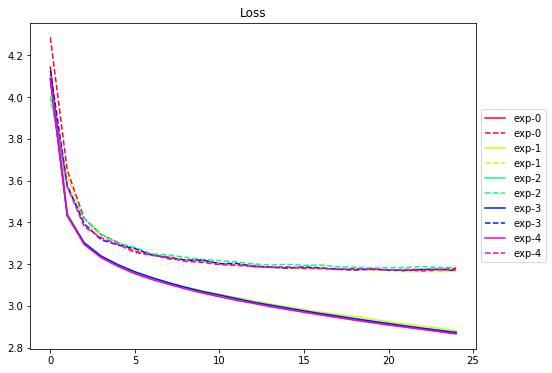

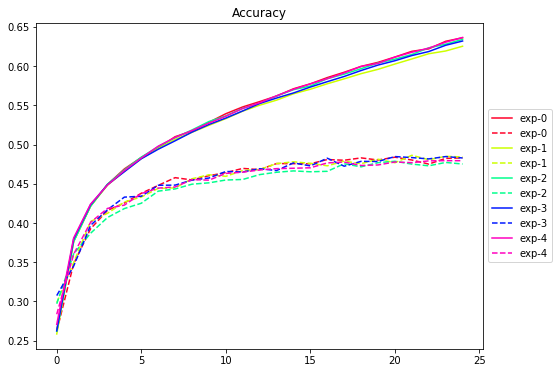

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()